In [1]:
%load_ext rpy2.ipython

## Imports

In [4]:
import pandas as pd
import os 
from celloracle import motif_analysis as ma
import pandas as pd
import celloracle as co
celloracle_dir = '../output/celloracle'
cicero_dir = '../output/cicero'
os.makedirs(cicero_dir, exist_ok=True)
donor_id = 'donor_0'
cell_type = 'B cells'

## Get data of the competition

In [ ]:
multiome_var_meta = pd.read_csv('../input/open-problems-single-cell-perturbations/multiome_var_meta.csv')
multiome_train = pd.read_parquet('../input/open-problems-single-cell-perturbations/multiome_train.parquet')
multiome_obs_meta = pd.read_csv('../input/open-problems-single-cell-perturbations/multiome_obs_meta.csv')

In [ ]:
# extract only peaks
peaks_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Peaks']['location'].values
df_peaks = multiome_train[multiome_train['location'].isin(peaks_locations)].reset_index(drop=True)
del multiome_train

## Get annotation

In [ ]:
# Get chromosome sizes (for hg38 here). 
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]

chromsizes = chromsizes[['Chromosome', 'End']]
# save
chromsizes.to_csv('output/chromsizes.csv', index=False)

## Extract the peaks and save them

In [7]:
# extract peaks for donor and cell type
obs_donor = multiome_obs_meta[multiome_obs_meta['donor_id']==donor_id]
obs_donor_cell_type = obs_donor[obs_donor['cell_type']==cell_type]
df_peaks_cell_type = df_peaks[df_peaks['obs_id'].isin(obs_donor_cell_type['obs_id'].values)].reset_index(drop=True)
# format and save
def format(df):
    df.loc[:, 'location'] = df.location.str.replace(':','_')
    df.loc[:, 'location'] = df.location.str.replace('-','_')
    return  df
df_peaks_cell_type = format(df_peaks_cell_type)
df_peaks_cell_type[['location','obs_id','count']].to_csv(f'output/scATAC/{donor_id}_{cell_type}.txt', sep='\t', header=None, index=False)

In [ ]:
# check if all chr are found
chrs = df_peaks_cell_type.location.apply(lambda x:x.split('_')[0])
chrs.isin(chromsizes.Chromosome).sum()

## Run cicero

In [4]:
%%R -i donor_id -i cell_type -i cicero_dir
library(Gviz)
library(GenomicRanges)
library(rtracklayer)
library(cicero)
set.seed(2017)
packageVersion("cicero")
# get the peaks
cicero_data <- read.table(paste0("output/scATAC/", donor_id, "_", cell_type, ".txt"), sep = "\t", header = FALSE)
input_cds <- make_atac_cds(cicero_data, binarize = TRUE)
input_cds <- monocle3::detect_genes(input_cds)
input_cds <- estimate_size_factors(input_cds)
input_cds <- preprocess_cds(input_cds, method = "LSI")
input_cds <- reduce_dimension(input_cds, reduction_method = 'UMAP', preprocess_method = "LSI")
# reduced dimension and cicero object
umap_coords <- reducedDims(input_cds)$UMAP
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = umap_coords)
# read chromsize
chromsizes <- read.csv('output/chromsizes.csv')
# actual run
conns <- run_cicero(cicero_cds, chromsizes)
# save all peaks and connections
all_peaks <- row.names(exprs(input_cds))
write.csv(x = all_peaks, file = paste0(cicero_dir, "/", "all_peaks_", donor_id,"_", cell_type,".csv"))
write.csv(x = conns, file = paste0(cicero_dir, "/", "connections_", donor_id,"_", cell_type,".csv"))

[1] '1.3.9'

## Associate peaks with TSS
Each peak is associated with promotors of target genes (+- 1kbp). Celloracle should be installed for this step.

In [10]:
peaks = pd.read_csv(f"{cicero_dir}/all_peaks_donor_0_B cells.csv", index_col=0)
cicero_connections =  pd.read_csv(f"{cicero_dir}/connections_{donor_id}_{cell_type}.csv", index_col=0)

In [11]:
tss_annotated = ma.get_tss_info(peak_str_list=peaks['x'].values, ref_genome="hg38")


que bed peaks: 131047
tss peaks in que: 20898


***** WARNING: File /tmp/pybedtools.79st2oi9.tmp has inconsistent naming convention for record:
GL000194.1	55749	56580

***** WARNING: File /tmp/pybedtools.79st2oi9.tmp has inconsistent naming convention for record:
GL000194.1	55749	56580



In [13]:
tss_annotated.to_csv('../output/celloracle/tss_annotated.csv')

## Merge TSS peaks with cicero connections

In [15]:
integrated = ma.integrate_tss_peak_with_cicero(tss_peak=tss_annotated, 
                                               cicero_connections=cicero_connections)
integrated.to_csv('../output/celloracle/integrated.csv')

## Shortlisten the peak-gene connections

In [7]:
peak_gene = integrated[integrated.coaccess>0.8].reset_index(drop=True)
peak_gene.to_csv('../output/scenicplus/peak_gene.csv')

## Create base GRN
Running interactively might take a long time.

In [6]:
# PLEASE make sure reference genome is correct.
ref_genome = "hg38"

genome_installation = ma.is_genome_installed(ref_genome=ref_genome,
                                             genomes_dir=None)
print(ref_genome, "installation: ", genome_installation)

# Instantiate TFinfo object
tfi = ma.TFinfo(peak_data_frame=peak_gene, 
                ref_genome="hg38",
                genomes_dir=None) 

tfi.scan(fpr=0.05, 
         motifs=None,  # If you enter None, default motifs will be loaded.
         verbose=True)
# Check motif scan results
tfi.scanned_df.head()
# Reset filtering 
tfi.reset_filtering()

# Do filtering
tfi.filter_motifs_by_score(threshold=10)

# Format post-filtering results.
tfi.make_TFinfo_dataframe_and_dictionary(verbose=True)

# Format and save 
df = tfi.to_dataframe()
df.head()
df.to_csv('../output/celloracle/grn_celloracle_base.csv')


## Network construction


### Preprocessing scRNA-seq

In [93]:
import pandas as pd
import celloracle as co
import anndata
import scanpy as sc
adata = anndata.read_h5ad('../output/scRNA/adata_donor_0.h5ad')

In [94]:
sc.tl.diffmap(adata)
# Calculate neihbors again based on diffusionmap 
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

In [95]:
sc.tl.louvain(adata, resolution=0.8)

In [96]:
sc.tl.paga(adata, groups='louvain')


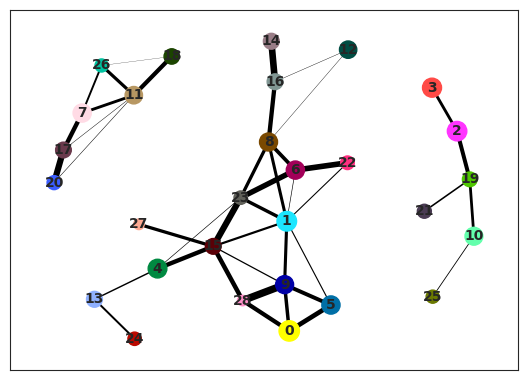

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [6, 4.5]
sc.pl.paga(adata)


In [98]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)


In [7]:
# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['cell_type', 'donor_id', 'louvain']
Dimensional reduction:  ['X_pca', 'X_umap', 'X_diffmap', 'X_draw_graph_fr']


In [99]:
## run based on counts as suggesyed by co pipeline
adata.X = adata.layers["counts"].copy()

### Load base GRN

In [91]:
base_GRN = pd.read_csv('../output/celloracle/grn_celloracle_base.csv', index_col=0)

### Initialize 

22787 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


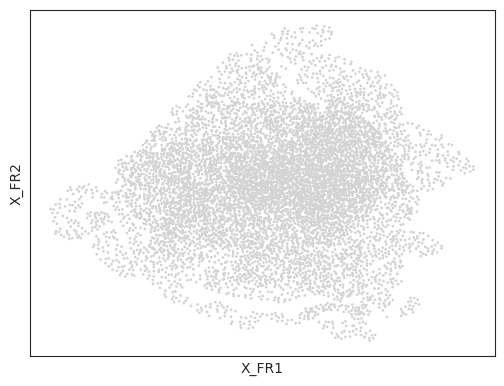

KeyError: 'None_colors'

In [100]:
# Instantiate Oracle object
oracle = co.Oracle()
# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                #    cluster_column_name="cell_type",
                                   embedding_name="X_draw_graph_fr")

In [11]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)


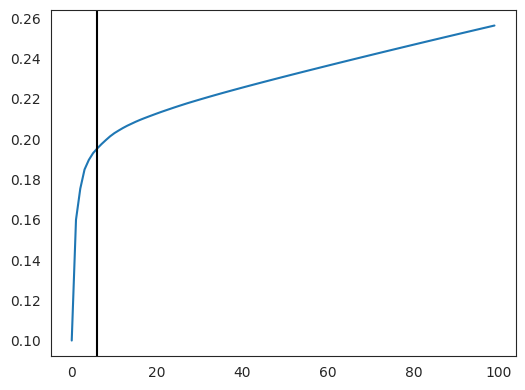

6


In [13]:
import numpy as np
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [14]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")
k = min([int(0.025*n_cell), 50])
print(f"Auto-selected k is :{k}")
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

cell number is :7830
Auto-selected k is :50


In [16]:
oracle.to_hdf5('../output/celloracle/presaved.celloracle.oracle')

### GRN calculation


In [ ]:
# Load file.
oracle = co.load_hdf5('../output/celloracle/presaved.celloracle.oracle')

In [18]:
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit="cell_type", alpha=10,
                         verbose_level=10)
links.to_hdf5(file_path="../output/celloracle/links.celloracle.links")

# Further Evaluation  

## Peak gene connections


In [19]:
tss_annotated = pd.read_csv('../output/celloracle/tss_annotated.csv')
print(len(tss_annotated))
integrated = pd.read_csv('../output/celloracle/integrated.csv')
print(len(integrated))
peak_gene_shortlist = pd.read_csv('../output/scenicplus/peak_gene.csv')
print(len(peak_gene_shortlist))

20898
368086
19114


In [20]:
# convert peak to peak_id using celloracle function
tss_annotated_df = pd.DataFrame({"peak_id": ma.process_bed_file.df_to_list_peakstr(tss_annotated),
                            "gene_short_name": tss_annotated.gene_short_name.values})

In [18]:
# number of tss_annotated pairs in shortlisted peak
print(f'Percentage of proximal elements in the final peak gene pairs: {100*peak_gene_shortlist.peak_id.isin(tss_annotated_df.peak_id).sum()/len(peak_gene_shortlist)}')

Percentage of proximal elements in the final peak gene pairs: 99.98953646541801


In [21]:
dorc_shortlisted = peak_gene_shortlist.groupby('gene_short_name').size()
print(f"In the short list: max peaks per gene: {dorc_shortlisted.max()}, median: {dorc_shortlisted.median()}")


In the short list: max peaks per gene: 8, median: 1.0


In [23]:
threshold = 10
peak_new = integrated[integrated.coaccess >= threshold]
print('number of DORC: ', (peak_new.groupby('gene_short_name').size()>10).sum())

number of DORC:  0


## Base GRN

In [24]:
base_GRN = pd.read_csv('../output/celloracle/grn_celloracle_base.csv', index_col=0)

In [45]:
tfs_co = base_GRN.columns[3:]
keeo_cols = tfs_co.insert(0, ['gene_short_name', 'peak_id'])
df = base_GRN[keeo_cols]
# Melting the DataFrame
melted_df = pd.melt(df, id_vars=['gene_short_name', 'peak_id'], var_name='TF', value_name='Link')

# Filtering out rows where there is no link (optional, if you only want interactions)
melted_df = melted_df[melted_df['Link'] == 1]

In [46]:
print(f'TFs : {melted_df.TF.unique().shape} , regions : {melted_df.peak_id.unique().shape},  genes : {melted_df.gene_short_name.unique().shape}')

TFs : (1113,) , regions : (17167,),  genes : (16614,)


## Refined GRN 

In [63]:
links = co.load_hdf5("../output/celloracle/links.celloracle.links")
links.filter_links(p=0.05, weight="coef_abs", threshold_number=2000)


In [64]:
links_stack = []
cell_types = list(links.links_dict.keys())
links_celltype = links.links_dict[cell_types[2]]
print(f'TFs : {links_celltype.source.unique().shape} , genes : {links_celltype.target.unique().shape}')

TFs : (596,) , genes : (13806,)


In [87]:
grn_stack = []
for i, cell_type in enumerate(cell_types):
    grn_celltype = links.links_dict[cell_type]
    grn_celltype = grn_celltype[~(grn_celltype.coef_mean==0)][['source', 'target', 'coef_mean']] # remove those with 0 coeff
    grn_celltype.columns = ['source', 'target', f'weight_{cell_type}']
    grn_stack.append(grn_celltype)

In [89]:
from functools import reduce
merged_grn = reduce(lambda  left,right: pd.merge(left,right,on=['source', 'target'],
                                            how='inner'), grn_stack)


In [90]:
merged_grn.to_csv('../output/celloracle/merged_grn.csv')